In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg-static\\ffmpeg-20160919-11777eb-win64-static\\bin\\ffmpeg.exe'



from tempfile import NamedTemporaryFile
import base64

from scipy.integrate import odeint

%matplotlib inline

We want to solve the barotropic, quasigeostrophic potential vorticity equation
$$ {\partial q\over\partial t} = -J(\psi, q) - \beta{\partial\psi\over\partial x} + \kappa\nabla^2 q + F,$$
where $q$ is the potential vorticity (PV) anomaly; $\psi$ is the velocity streamfunction;  $J(,)$ is the Jacobian operator; $\kappa$ is the (eddy) viscosity; and $F$ is a forcing function.  In the barotropic case (which we're studying), the PV anomaly is defined as $$q = \nabla^2 \psi.$$

We will calculate spatial derivatives pseudospectrally. Our boundary conditions are periodic, which means we can use a Fourier series instead of Chebyshev series (which is marginally more complicated, and required for rigid boundaries).

We're going to use an integrator provided by `scipy.integrate` for time integration. To do so, we need to write a function for the right hand side of the equation above.




## Set up a trial function and plot

In [3]:
x = np.linspace(-np.pi, np.pi, 512, endpoint=False)
y = np.linspace(-np.pi, np.pi, 512, endpoint=False)

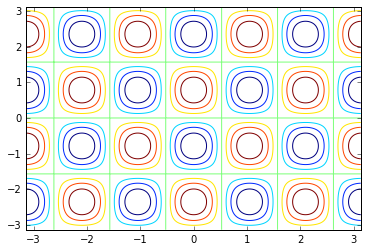

In [4]:
xx, yy = np.meshgrid(x,y)
field = np.cos(3*xx)*np.sin(2*yy)
plt.contour(xx, yy, field)

## Take derivatives in Fourier space

Since our function is real, we get some computational savings by using `rfft` instead of `fft`.

In [5]:
foo = np.fft.rfft2(field)

In [6]:
kx = np.fft.rfftfreq(512, 1.0/512)
ky = np.fft.fftfreq(512, 1.0/512)
kkx, kky = np.meshgrid(kx,ky)

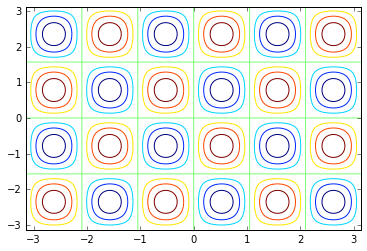

In [7]:
bar = foo * kkx*(0+1.0j)
baz = np.fft.irfft2(bar)
plt.contour(xx, yy, baz)

In [8]:
baz.max()

3.0000000000003397

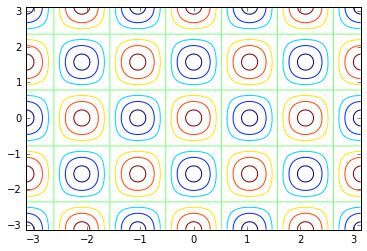

In [9]:
bar = foo * kky*(0+1.0j)
baz = np.fft.irfft2(bar)
plt.contour(xx, yy, baz)

In [10]:
field.max()

1.0

In [11]:
baz.max()

2.0000000000000338

In [12]:
foo[2,3]

(2.8443828553369025e-11+65536j)

## A different test function

Put some amplitude in a couple of arbitrary modes. The value is nx*ny

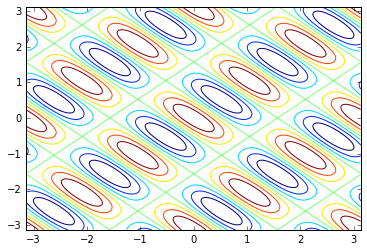

In [13]:
tester = np.zeros_like(foo)

tester[4,2] = 65536
tester[2,4] = 65536

xyzzy = np.fft.irfft2(tester)
plt.contour(xx, yy, xyzzy)

In [14]:
#### Parameters from my old fortran code


#lx = param("lx",1.0e6_r8,0)
#    ly = param("ly",2.0e6_r8,0)
#    beta = param("beta",2.0e-11_r8,0)
#    kappa = param("kappa",1.0e3_r8,0)
#    fzero = param("fzero",1.0e-4_r8,0)
#    w = param("w",1.0e-6_r8,0)
#    thick1 = param("thick1",1.0e3_r8,0)
#    r = param("r",1.0e-10_r8,0)
#    asymmetry = param("asymmetry",0.0_r8,0)
#    biharmonic = param("biharmonic", .true., 0)



## Pull this together into a class

This will go in a module once we get things nailed down.

In [7]:
class flow(object):
    def __init__(self, nx=256, ny=256, lx=1.0e6, ly=2.0e6, beta=6.0e-10, kappa=10.0, w=4.0e-6, forcing_mode=(6,9)):
        x = np.linspace(-np.pi, np.pi, nx, endpoint=False)
        y = np.linspace(-np.pi, np.pi, ny, endpoint=False)
        self.xx, self.yy = np.meshgrid(x,y)
        
        kx = np.fft.rfftfreq(nx, lx/nx)
        ky = np.fft.fftfreq(ny, ly/ny)
        self.kkx, self.kky = np.meshgrid(kx,ky)
        
        self.ksq = self.kkx**2 + self.kky**2
        self.ksq[0,0] += 1.0e-15
        self.kmax = np.min(np.max(kx), np.max(ky))
        
        self.nx = nx
        self.ny = ny
        self.lx = lx
        self.ly = ly
        self.beta = beta
        self.kappa = kappa
        self.w = w
        
        self.forcing_mode = forcing_mode

        self.psihat = np.zeros((nx,int(ny/2+1)), dtype=complex)
        self.psihat[2,4] = nx*ny*4
        self.psihat[4,2] = nx*ny
        
        self.psi = np.fft.irfft2(self.psihat)
        
        self.qhat = -self.psihat*self.ksq
        self.q = np.fft.irfft2(self.qhat)
        
    def plot_psi(self):
        return plt.contour(self.xx, self.yy, self.psi)
        
    def plot_q(self):
        return plt.contour(self.xx, self.yy, self.q)
        
        
    def get_psihat_from_qhat(self, qhat):
        """What it says on the tin.        
        """
        
        psihat = qhat/self.ksq
        return psihat
        
    def waveterm(self, psihat):
        """Compute the beta wave term.
        
        Assume that we start and end in Fourier space.
        """
        return self.beta*psihat*self.kkx*(0.0+1.0j)
    
    def dissipation(self, qhat):
        """Dissipation term, all in Fourier space."""
        
        return self.kappa*qhat*self.ksq
    
    def forcing(self, t):
        """Forcing term goes here.
        
        This ought to be random phases into a k-space anulus, but I'll use something simple for now.
        """
        fzero = 1.0e-4
        thick = 1.0e3
        famp = self.w * fzero/thick

        phases = np.random.uniform(-np.pi, np.pi, size=self.qhat.shape)
        
        forcing = np.zeros_like(self.qhat, dtype=complex)
        forcing[np.abs(self.ksq - self.kmax**2/9) < 3e-11] = famp
        forcing *= np.cos(phases) + np.sin(phases)*(0.0+1.0j)
        
        return forcing
    
    def nlterm(self, qhat, psihat):
        """Compute the jacobian determinant."""
        
        # dealias
        qhat[self.ksq>2/3*self.kmax] = 0.0
        psihat[self.ksq>2/3*self.kmax] = 0.0
        
        psihat_x = psihat*self.kkx*(0.0+1.0j)
        psihat_y = psihat*self.kky*(0.0+1.0j)
        qhat_x = qhat*self.kkx*(0.0+1.0j)
        qhat_y = qhat*self.kky*(0.0+1.0j)
        
        psi_x = np.fft.irfft2(psihat_x)
        psi_y = np.fft.irfft2(psihat_y)
        q_x = np.fft.irfft2(qhat_x)
        q_y = np.fft.irfft2(qhat_y)
        
        jac = psi_x*q_y - psi_y*q_x
        
        jachat = np.fft.rfft2(jac)
        return jachat
    
    def rhs(self, q_reshaped, t):
        """The time derivative, ready for the integrator."""
        
        qhat = self.unmunge(q_reshaped)
        
        psihat = self.get_psihat_from_qhat(qhat)
        nlterm = self.nlterm(qhat, psihat)
        waveterm = self.waveterm(psihat)
        dissipation = self.dissipation(qhat)
        forcing = self.forcing(t)
        
        return self.munge(forcing - dissipation + waveterm + nlterm)
    
    def munge(self, qhat):
        """format a complex k-space field for odeint"""
        
        r = qhat.real
        i = qhat.imag
        z = np.array([r,i])
        return z.reshape(-1)
    
    def unmunge(self, munged):
        """Return the 1d real sequence to its 2d complex state"""
        
        z = munged.reshape((2,self.nx,int(self.ny/2+1)))
        r = z[0]
        i = z[1]
        return r + (0+1.0j)*i

In [16]:
foo = flow()

C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


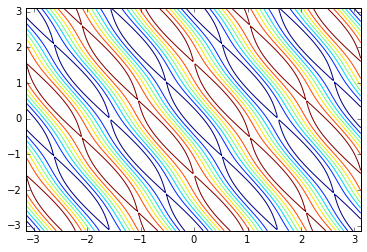

In [17]:
cont = foo.plot_q()

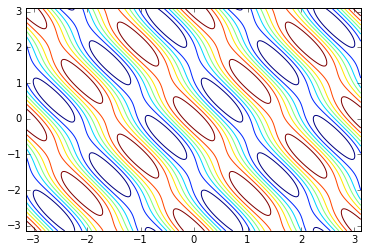

In [18]:
foo.plot_psi()

In [8]:
unforced = flow(w=0)


t = np.linspace(0, 3600*24*7*3, 120)

result = odeint(unforced.rhs, unforced.munge(unforced.qhat), t)

C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


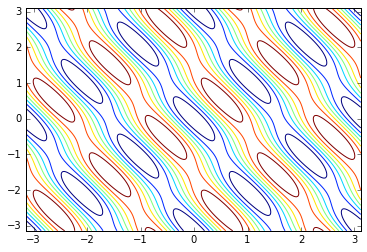

In [20]:
field = result[0]
plt.contour(unforced.xx, unforced.yy, np.fft.irfft2(unforced.get_psihat_from_qhat(unforced.unmunge(field))))

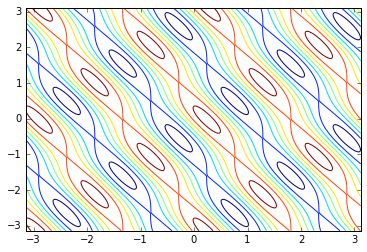

In [21]:
field = result[119]
plt.contour(unforced.xx, unforced.yy, np.fft.irfft2(unforced.get_psihat_from_qhat(unforced.unmunge(field))))

These are pretty clearly different.  To get a better sense of what's going on, let's animate it.

In [21]:
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20)
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)
    
    return VIDEO_TAG.format(anim._encoded_video.decode('ascii'))

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

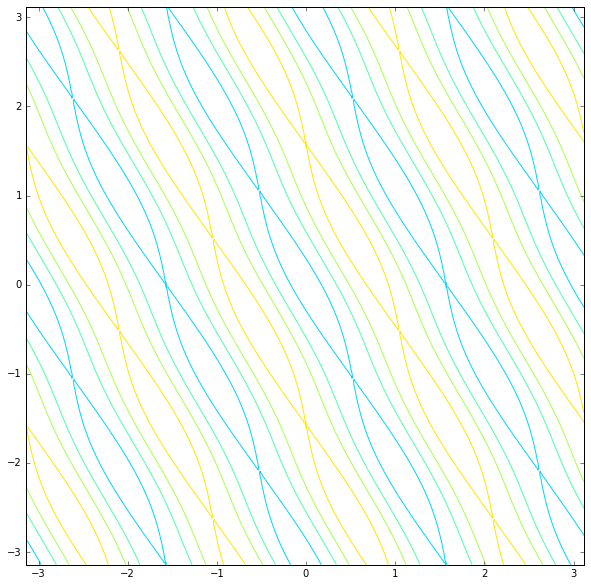

In [16]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel(r'x')
plt.ylabel(r'y')

totalmax = np.max([np.max(np.abs(np.fft.irfft2(unforced.unmunge(frame)))) for frame in result])
levels = np.linspace(-totalmax, totalmax, 10)

# animation function
def animate(i): 
    z = np.fft.irfft2(unforced.unmunge(result[i]))
    ax.clear()
    
    cont = plt.contour(unforced.xx, unforced.yy, z, levels)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=len(t), blit=False)
mywriter = animation.FFMpegWriter()

anim.save("animation.mp4", writer=mywriter, fps=45, dpi=45, bitrate=4000)

In [26]:
totalmax = [np.fft.irfft2(unforced.unmunge(frame)) for frame in result]
np.max(totalmax[2])


1.5192459714253158e-10

In [27]:
totalmin = min([min(frame) for frame in result])
totalmin

-4.5021536955042549e-06

In [28]:
t = np.linspace(0, 3600*24*7*5, 240)
result = odeint(unforced.rhs, unforced.munge(unforced.qhat), t)

In [29]:
levels

array([ -1.54253592e-10,  -1.23402874e-10,  -9.25521555e-11,
        -6.17014370e-11,  -3.08507185e-11,   0.00000000e+00,
         3.08507185e-11,   6.17014370e-11,   9.25521555e-11,
         1.23402874e-10,   1.54253592e-10])

OSError: [Errno 22] Invalid argument

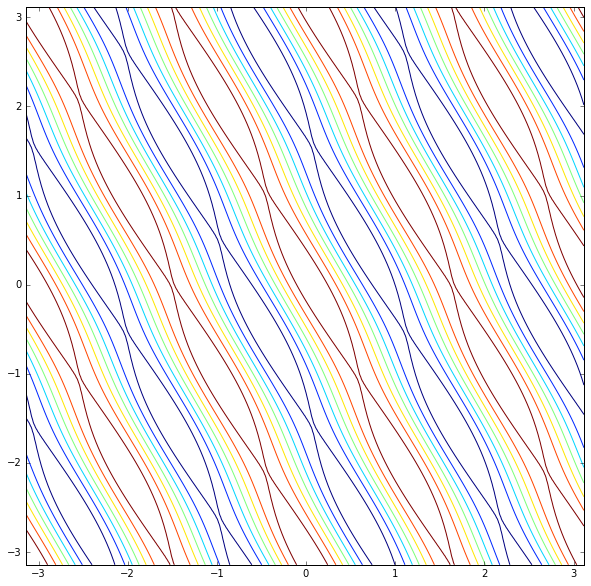

In [35]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel(r'x')
plt.ylabel(r'y')

# animation function
def animate(i): 
    z = np.fft.irfft2(unforced.unmunge(result[i]))
    ax.clear()
    cont = plt.contour(unforced.xx, unforced.yy, z)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=len(t))
mywriter=animation.FFMpegWriter()
anim.save("longer.mp4", writer=mywriter, fps=30)

In [34]:
#unforced = flow(w=0, kappa=-2.0e3)

#t = np.linspace(0, 3600*24*7*5, 50)
#result = odeint(unforced.rhs, unforced.munge(unforced.qhat), t)
#fig = plt.figure()
#ax = plt.axes()  
#plt.xlabel(r'x')
#plt.ylabel(r'y')

# animation function
#def animate(i): 
#    z = np.fft.irfft2(unforced.unmunge(result[i]))
#    ax.clear()
#    cont = plt.contour(unforced.xx, unforced.yy, z)
#    return cont  


#anim = animation.FuncAnimation(fig, animate, frames=len(t))
#mywriter=animation.FFMpegWriter()
#display_animation(anim)

In [ ]:
forced = flow(kappa=5.0e3)

t = np.linspace(0, 3600*24*7*100, 500)
contours = np.linspace(-1.5e-7, 1.5e-7, 15)
result = odeint(forced.rhs, forced.munge(forced.qhat), t)

fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel(r'x')
plt.ylabel(r'y')

totalmax = np.max([np.max(np.abs(np.fft.irfft2(forced.unmunge(frame)))) for frame in result])
levels = np.linspace(-totalmax, totalmax, 11)

# animation function
def animate(i): 
    z = np.fft.irfft2(forced.unmunge(result[i]))
    ax.clear()
    cont = plt.contour(forced.xx, forced.yy, z, levels)
    return cont  
mywriter = animation.FFMpegWriter()
anim = animation.FuncAnimation(fig, animate, frames=len(t))

anim.save("forced.mp4", writer=mywriter, bitrate=4000)

C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


In [ ]:
max(abs(np.fft.irfft2(forced.unmunge(result[10])).reshape(-1)))

In [ ]:
nx = 256
lx = 1.0e6
kx = np.fft.rfftfreq(nx, lx/nx)

In [ ]:
ny = 512
psihat = np.zeros((nx,int(ny/2+1)), dtype=complex)

In [38]:
forcing = np.zeros_like(forced.qhat, dtype=complex)
forcing[np.abs(forced.ksq - forced.kmax**2/9) < 3e-11] = 1.0

In [39]:
np.sum(forcing)

(187+0j)

In [29]:
np.max(forced.ksq)

2.0479999999999999e-08

In [31]:
forced.kmax**2/9

1.8204444444444444e-09

In [22]:
forced.ksq[0,1] - forced.ksq[0,2]

-3.0000000000000001e-12

In [46]:
np.random.uniform(-np.pi, np.pi, size=forced.qhat.shape)

array([[ 3.11944284, -2.64806497,  1.75593401, ...,  0.21594424,
         0.24282999, -1.29512376],
       [-1.15351055, -2.66160221, -0.6554231 , ..., -2.21612756,
         0.32168191,  2.64656531],
       [-2.39040617, -1.88601091, -2.05906808, ..., -0.21530523,
         2.58734948, -3.05869671],
       ..., 
       [ 0.34049231,  3.04456498,  0.44628101, ..., -2.6426708 ,
        -2.44860247, -1.11424056],
       [-1.7680833 , -1.78662955,  2.80282091, ...,  2.97939247,
        -0.86106483, -1.48172929],
       [-0.65275039,  0.18383808, -1.40813199, ..., -2.88105067,
         2.84485408,  1.60964354]])

In [6]:
unforced = flow(w=0.0)

phases = np.random.uniform(-np.pi, np.pi, size=unforced.qhat.shape)
        
forcing = np.zeros_like(unforced.qhat, dtype=complex)
forcing[np.abs(unforced.ksq - unforced.kmax**2/9) < 3e-11] = 1.0
forcing *= np.cos(phases) + np.sin(phases)*(0.0+1.0j)
        

C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


In [10]:
forcing[forcing != 0]

array([ 0.89549069-0.44508025j, -0.76557563+0.64334591j,
        0.31946969-0.9475965j ,  0.38667144+0.92221755j,
       -0.97964179-0.20075347j,  0.88489236+0.46579557j,
       -0.84830799-0.52950312j, -0.11291471-0.99360468j,
        0.97027058-0.24202273j, -0.51284777+0.85847956j,
       -0.85063662+0.52575407j,  0.99799509+0.06329133j,
        0.60837203+0.79365198j, -0.83353399-0.55246818j,
        0.97794349+0.20886967j,  0.11589022-0.99326203j,
       -0.98044006-0.1968179j , -0.72650133+0.68716505j,
       -0.21732200+0.97609997j, -0.56281719-0.8265814j ,
        0.20144537-0.97949975j, -0.98710158+0.16009522j,
        0.99814832+0.060827j  ,  0.24852659-0.96862507j,
       -0.26676620+0.96376127j,  0.94838912+0.31710892j,
       -0.45029777-0.89287845j,  0.05604298-0.99842836j,
        0.16788839+0.98580601j,  0.99602134+0.08911499j,
        0.96650058+0.25666444j,  0.83798950-0.54568635j,
       -0.53661992-0.84382407j, -0.76869699+0.63961311j,
       -0.13563727+0.99075856j,

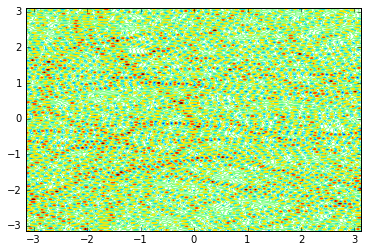

In [12]:
junk = np.fft.irfft2(forcing)
plt.contour(unforced.xx, unforced.yy, junk)